<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Diffusion_RL/OffQL-Bandit%20task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main

In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

actions

In [4]:
#data generation

a = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0.0, 1.0]), covariance_matrix=torch.tensor([[0.005, 0],[0, 0.005]]) )
b = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([1.0, 0.0]), covariance_matrix=torch.tensor([[0.005, 0],[0, 0.005]]) )
c = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-1.0, 0.0]), covariance_matrix=torch.tensor([[0.005, 0],[0, 0.005]]) )
d = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0, -1.0]), covariance_matrix=torch.tensor([[0.005, 0],[0, 0.005]]) )


n1 = a.sample((2500,))
n2 = b.sample((2500,))
n3 = c.sample((2500,))
n4 = d.sample((2500,))

In [5]:
mvn = torch.concat([n1,n2,n3,n4], dim=0)

In [8]:
mvn.shape

torch.Size([10000, 2])

In [6]:
x, y = mvn.split(1, dim = 1)

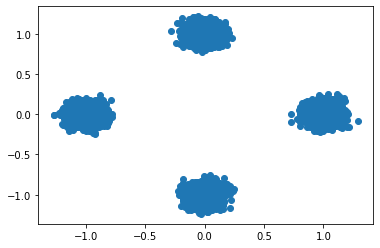

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.show()

In [8]:
#reward

std = torch.ones(2500)*0.5
mean1 = torch.ones(2500)*3.0
mean2 = torch.ones(2500)*1.5
mean3 = torch.ones(2500)*0.0
mean4 = torch.ones(2500)*5.0

ra = torch.normal(mean1, std)
rb = torch.normal(mean2, std)
rc = torch.normal(mean3, std)
rd = torch.normal(mean4, std)

rew = torch.concat([ra,rb,rc,rd])

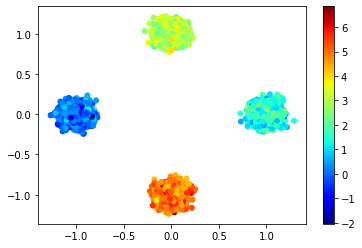

In [9]:
points = plt.scatter(x, y, c=rew,cmap="jet", lw=0)
plt.colorbar(points)

In [10]:
state = torch.ones((10_000, 1))

In [11]:
next_state = torch.ones((10_000,1))

In [12]:
reward = torch.unsqueeze(rew, dim=1)

In [13]:
comb = torch.cat([state, x,y, next_state, reward], dim=1)

Helpers

In [14]:
import time
import math
import torch
import numpy as np


def print_banner(s, separator="-", num_star=60):
	print(separator * num_star, flush=True)
	print(s, flush=True)
	print(separator * num_star, flush=True)


class Progress:

	def __init__(self, total, name='Progress', ncol=3, max_length=20, indent=0, line_width=100, speed_update_freq=100):
		self.total = total
		self.name = name
		self.ncol = ncol
		self.max_length = max_length
		self.indent = indent
		self.line_width = line_width
		self._speed_update_freq = speed_update_freq

		self._step = 0
		self._prev_line = '\033[F'
		self._clear_line = ' ' * self.line_width

		self._pbar_size = self.ncol * self.max_length
		self._complete_pbar = '#' * self._pbar_size
		self._incomplete_pbar = ' ' * self._pbar_size

		self.lines = ['']
		self.fraction = '{} / {}'.format(0, self.total)

		self.resume()

	def update(self, description, n=1):
		self._step += n
		if self._step % self._speed_update_freq == 0:
			self._time0 = time.time()
			self._step0 = self._step
		self.set_description(description)

	def resume(self):
		self._skip_lines = 1
		print('\n', end='')
		self._time0 = time.time()
		self._step0 = self._step

	def pause(self):
		self._clear()
		self._skip_lines = 1

	def set_description(self, params=[]):

		if type(params) == dict:
			params = sorted([
				(key, val)
				for key, val in params.items()
			])

		############
		# Position #
		############
		self._clear()

		###########
		# Percent #
		###########
		percent, fraction = self._format_percent(self._step, self.total)
		self.fraction = fraction

		#########
		# Speed #
		#########
		speed = self._format_speed(self._step)

		##########
		# Params #
		##########
		num_params = len(params)
		nrow = math.ceil(num_params / self.ncol)
		params_split = self._chunk(params, self.ncol)
		params_string, lines = self._format(params_split)
		self.lines = lines

		description = '{} | {}{}'.format(percent, speed, params_string)
		print(description)
		self._skip_lines = nrow + 1

	def append_description(self, descr):
		self.lines.append(descr)

	def _clear(self):
		position = self._prev_line * self._skip_lines
		empty = '\n'.join([self._clear_line for _ in range(self._skip_lines)])
		print(position, end='')
		print(empty)
		print(position, end='')

	def _format_percent(self, n, total):
		if total:
			percent = n / float(total)

			complete_entries = int(percent * self._pbar_size)
			incomplete_entries = self._pbar_size - complete_entries

			pbar = self._complete_pbar[:complete_entries] + self._incomplete_pbar[:incomplete_entries]
			fraction = '{} / {}'.format(n, total)
			string = '{} [{}] {:3d}%'.format(fraction, pbar, int(percent * 100))
		else:
			fraction = '{}'.format(n)
			string = '{} iterations'.format(n)
		return string, fraction

	def _format_speed(self, n):
		num_steps = n - self._step0
		t = time.time() - self._time0
		speed = num_steps / t
		string = '{:.1f} Hz'.format(speed)
		if num_steps > 0:
			self._speed = string
		return string

	def _chunk(self, l, n):
		return [l[i:i + n] for i in range(0, len(l), n)]

	def _format(self, chunks):
		lines = [self._format_chunk(chunk) for chunk in chunks]
		lines.insert(0, '')
		padding = '\n' + ' ' * self.indent
		string = padding.join(lines)
		return string, lines

	def _format_chunk(self, chunk):
		line = ' | '.join([self._format_param(param) for param in chunk])
		return line

	def _format_param(self, param):
		k, v = param
		return '{} : {}'.format(k, v)[:self.max_length]

	def stamp(self):
		if self.lines != ['']:
			params = ' | '.join(self.lines)
			string = '[ {} ] {}{} | {}'.format(self.name, self.fraction, params, self._speed)
			self._clear()
			print(string, end='\n')
			self._skip_lines = 1
		else:
			self._clear()
			self._skip_lines = 0

	def close(self):
		self.pause()


class Silent:

	def __init__(self, *args, **kwargs):
		pass

	def __getattr__(self, attr):
		return lambda *args: None


class EarlyStopping(object):
	def __init__(self, tolerance=5, min_delta=0):
		self.tolerance = tolerance
		self.min_delta = min_delta
		self.counter = 0
		self.early_stop = False

	def __call__(self, train_loss, validation_loss):
		if (validation_loss - train_loss) > self.min_delta:
			self.counter += 1
			if self.counter >= self.tolerance:
				return True
		else:
			self.counter = 0
		return False

In [15]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

#-----------------------------------------------------------------------------#
#---------------------------------- sampling ---------------------------------#
#-----------------------------------------------------------------------------#


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))




def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2, dtype=torch.float32):
    betas = np.linspace(
        beta_start, beta_end, timesteps
    )
    return torch.tensor(betas, dtype=dtype)


#-----------------------------------------------------------------------------#
#---------------------------------- losses -----------------------------------#
#-----------------------------------------------------------------------------#

class WeightedLoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, pred, targ, weights=1.0):
        '''
            pred, targ : tensor [ batch_size x action_dim ]
        '''
        loss = self._loss(pred, targ)
        weighted_loss = (loss * weights).mean()
        return weighted_loss

class WeightedL1(WeightedLoss):

    def _loss(self, pred, targ):
        return torch.abs(pred - targ)

class WeightedL2(WeightedLoss):

    def _loss(self, pred, targ):
        return F.mse_loss(pred, targ, reduction='none')


Losses = {
    'l1': WeightedL1,
    'l2': WeightedL2,
}


class EMA():
    '''
        empirical moving average
    '''
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

Diffusion

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    MLP Model
    """
    def __init__(self,
                 state_dim,
                 action_dim,
                 device,
                 t_dim=16):

        super(MLP, self).__init__()
        self.device = device

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(t_dim),
            nn.Linear(t_dim, t_dim * 2),
            nn.Mish(),
            nn.Linear(t_dim * 2, t_dim),
        )

        input_dim = state_dim + action_dim + t_dim
        self.mid_layer = nn.Sequential(nn.Linear(input_dim, 256),
                                       nn.Mish(),
                                       nn.Linear(256, 256),
                                       nn.Mish(),
                                       nn.Linear(256, 256),
                                       nn.Mish())

        self.final_layer = nn.Linear(256, action_dim)

    def forward(self, x, time, state):

        t = self.time_mlp(time)
        x = torch.cat([x, t, state], dim=1)
        x = self.mid_layer(x)

        return self.final_layer(x)

In [17]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F



class Diffusion(nn.Module):
    def __init__(self, state_dim, action_dim, model, max_action,
                n_timesteps=100, loss_type='l2', clip_denoised=True,
                 predict_epsilon=True):
        super(Diffusion, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action
        self.model = model


        betas = linear_beta_schedule(n_timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = torch.cat([torch.ones(1), alphas_cumprod[:-1]])

        self.n_timesteps = int(n_timesteps)
        self.clip_denoised = clip_denoised
        self.predict_epsilon = predict_epsilon

        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        self.register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance)

        ## log calculation clipped because the posterior variance
        ## is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped',
                             torch.log(torch.clamp(posterior_variance, min=1e-20)))
        self.register_buffer('posterior_mean_coef1',
                             betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        self.register_buffer('posterior_mean_coef2',
                             (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod))

        self.loss_fn = Losses[loss_type]()

    # ------------------------------------------ sampling ------------------------------------------#

    def predict_start_from_noise(self, x_t, t, noise):
        '''
            if self.predict_epsilon, model output is (scaled) noise;
            otherwise, model predicts x0 directly
        '''
        if self.predict_epsilon:
            return (
                    extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                    extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
            )
        else:
            return noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, s):
        x_recon = self.predict_start_from_noise(x, t=t, noise=self.model(x, t, s))

        if self.clip_denoised:
            x_recon.clamp_(-self.max_action, self.max_action)
        else:
            assert RuntimeError()

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    # @torch.no_grad()
    def p_sample(self, x, t, s):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, s=s)
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    # @torch.no_grad()
    def p_sample_loop(self, state, shape, verbose=False, return_diffusion=False):
        device = self.betas.device

        batch_size = shape[0]
        x = torch.randn(shape, device=device)

        if return_diffusion: diffusion = [x]

        progress = Progress(self.n_timesteps) if verbose else Silent()
        for i in reversed(range(0, self.n_timesteps)):
            timesteps = torch.full((batch_size,), i, device=device, dtype=torch.long)
            x = self.p_sample(x, timesteps, state)

            progress.update({'t': i})

            if return_diffusion: diffusion.append(x)

        progress.close()

        if return_diffusion:
            return x, torch.stack(diffusion, dim=1)
        else:
            return x

    # @torch.no_grad()
    def sample(self, state, *args, **kwargs):
        batch_size = state.shape[0]
        shape = (batch_size, self.action_dim)
        action = self.p_sample_loop(state, shape, *args, **kwargs)
        return action.clamp_(-self.max_action, self.max_action)

    # ------------------------------------------ training ------------------------------------------#

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sample = (
                extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

        return sample

    def p_losses(self, x_start, state, t, weights=1.0):
        noise = torch.randn_like(x_start)

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)

        x_recon = self.model(x_noisy, t, state)

        assert noise.shape == x_recon.shape

        if self.predict_epsilon:
            loss = self.loss_fn(x_recon, noise, weights)
        else:
            loss = self.loss_fn(x_recon, x_start, weights)

        return loss

    def loss(self, x, state, weights=1.0):
        batch_size = len(x)
        t = torch.randint(0, self.n_timesteps, (batch_size,), device=x.device).long()
        return self.p_losses(x, state, t, weights)

    def forward(self, state, *args, **kwargs):
        return self.sample(state, *args, **kwargs)

QL diffusion

In [18]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR





class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, 1))

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, hidden_dim),
                                      nn.Mish(),
                                      nn.Linear(hidden_dim, 1))

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.q1_model(x), self.q2_model(x)

    def q1(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.q1_model(x)

    def q_min(self, state, action):
        q1, q2 = self.forward(state, action)
        return torch.min(q1, q2)


class Diffusion_QL(object):
    def __init__(self,
                 state_dim,
                 action_dim,
                 max_action,
                 device,
                 discount,
                 tau,
                 max_q_backup=False,
                 eta=1.0,
                 n_timesteps=100,
                 ema_decay=0.995,
                 step_start_ema=1000,
                 update_ema_every=5,
                 lr=3e-4,
                 lr_decay=False,
                 lr_maxt=1000,
                 grad_norm=1.0,
                 ):

        self.model = MLP(state_dim=state_dim, action_dim=action_dim, device=device)

        self.actor = Diffusion(state_dim=state_dim, action_dim=action_dim, model=self.model, max_action=max_action,
                               n_timesteps=n_timesteps,).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr)

        self.lr_decay = lr_decay
        self.grad_norm = grad_norm

        self.step = 0
        self.step_start_ema = step_start_ema
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(self.actor)
        self.update_ema_every = update_ema_every

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        if lr_decay:
            self.actor_lr_scheduler = CosineAnnealingLR(self.actor_optimizer, T_max=lr_maxt, eta_min=0.)
            self.critic_lr_scheduler = CosineAnnealingLR(self.critic_optimizer, T_max=lr_maxt, eta_min=0.)

        self.state_dim = state_dim
        self.max_action = max_action
        self.action_dim = action_dim
        self.discount = discount
        self.tau = tau
        self.eta = eta  # q_learning weight
        self.device = device
        self.max_q_backup = max_q_backup

    def step_ema(self):
        if self.step < self.step_start_ema:
            return
        self.ema.update_model_average(self.ema_model, self.actor)

    def train(self, replay_buffer, iterations, batch_size=100):

        metric = {'bc_loss': [], 'ql_loss': [], 'actor_loss': [], 'critic_loss': []}
        for _ in range(iterations):
            # Sample replay buffer / batch
            
            perm = torch.randperm(replay_buffer.size(0))
            idx = perm[:batch_size]
            samples = replay_buffer[idx]
            state, actionx, actiony, next_state, reward = torch.chunk(samples, 5, dim=1)

            action = torch.concat([actionx, actiony],dim=1)

            """ Q Training """
            current_q1, current_q2 = self.critic(state, action)

            if self.max_q_backup:
                next_state_rpt = torch.repeat_interleave(next_state, repeats=10, dim=0)
                next_action_rpt = self.ema_model(next_state_rpt)
                target_q1, target_q2 = self.critic_target(next_state_rpt, next_action_rpt)
                target_q1 = target_q1.view(batch_size, 10).max(dim=1, keepdim=True)[0]
                target_q2 = target_q2.view(batch_size, 10).max(dim=1, keepdim=True)[0]
                target_q = torch.min(target_q1, target_q2)
            else:
                next_action = self.ema_model(next_state)
                target_q1, target_q2 = self.critic_target(next_state, next_action)
                target_q = torch.min(target_q1, target_q2)

            target_q = (reward + self.discount * target_q).detach()

            critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            if self.grad_norm > 0:
                critic_grad_norms = nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=self.grad_norm, norm_type=2)
            self.critic_optimizer.step()

            """ Policy Training """
            bc_loss = self.actor.loss(action, state)
            new_action = self.actor(state)

            q1_new_action, q2_new_action = self.critic(state, new_action)
            if np.random.uniform() > 0.5:
                q_loss = - q1_new_action.mean() / q2_new_action.abs().mean().detach()
            else:
                q_loss = - q2_new_action.mean() / q1_new_action.abs().mean().detach()
            actor_loss = bc_loss + self.eta * q_loss

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            if self.grad_norm > 0: 
                actor_grad_norms = nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=self.grad_norm, norm_type=2)
            self.actor_optimizer.step()


            """ Step Target network """
            if self.step % self.update_ema_every == 0:
                self.step_ema()

            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            self.step += 1

          

            metric['actor_loss'].append(actor_loss.item())
            metric['bc_loss'].append(bc_loss.item())
            metric['ql_loss'].append(q_loss.item())
            metric['critic_loss'].append(critic_loss.item())

        if self.lr_decay: 
            self.actor_lr_scheduler.step()
            self.critic_lr_scheduler.step()

        #return metric

    def sample_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        state_rpt = torch.repeat_interleave(state, repeats=50, dim=0)
        with torch.no_grad():
            action = self.actor.sample(state_rpt)
            q_value = self.critic_target.q_min(state_rpt, action).flatten()
            idx = torch.multinomial(F.softmax(q_value), 1)
        return action[idx].cpu().data.numpy().flatten()

In [56]:
diff_model = Diffusion_QL(state_dim = 1, action_dim = 2, max_action=10, device=device, discount= 0.99, tau=0.005)

In [57]:
diff_model.train(comb, 27_500)

In [58]:
new_s = torch.ones((1,1))
samp_lst = []
for _ in range(100):
    samp_lst.append(diff_model.sample_action(new_s))

<ipython-input-18-3d13683b752d>:185: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  idx = torch.multinomial(F.softmax(q_value), 1)


In [59]:
to_graph = np.stack(samp_lst)

In [1]:
to_graph

NameError: ignored

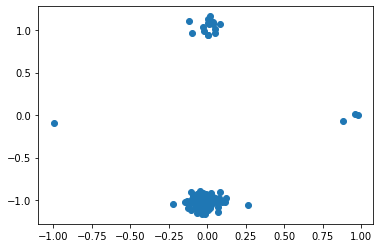

In [67]:
import matplotlib.pyplot as plt

plt.scatter(to_graph[:,0], to_graph[:,1])
plt.show()